Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2 as cv
from google.colab.patches import cv2_imshow
from scipy.signal import butter, lfilter
from scipy.signal import find_peaks
import scipy.fftpack
import math

Helper function for Bandpass filter 

In [ ]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter(order, [lowcut, highcut], btype='band')
    y = lfilter(b, a, data)
    return y

Read Video and get video parametres

In [ ]:
cap = cv.VideoCapture('/content/data/user5_horizontal_84bpm.mp4')

totalFrames = cap.get(cv.CAP_PROP_FRAME_COUNT)
height = cap.get(cv.CAP_PROP_FRAME_HEIGHT)
width = cap.get(cv.CAP_PROP_FRAME_WIDTH)
fps = cap.get(cv.CAP_PROP_FPS)

print(f"Frame Per second: {fps} \nTotal Frames: {totalFrames} \nHeight: {height} \nWidth: {width}")


Frame Per second: 30.0 
Total Frames: 611.0 
Height: 640.0 
Width: 360.0


For each video frame, get the mean of R,G, and B channel

In [ ]:
red_channel = []
green_channel = []
blue_channel = []

# Loop through frames
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:

        b,g,r = cv.split(frame)
        
        blue_channel.append(np.mean(b))
        green_channel.append(np.mean(g))
        red_channel.append(np.mean(r))
    else:
        break
cap.release()

x = np.arange(len(red_channel))
y = np.arange(len(blue_channel))
z = np.arange(len(green_channel))

Plotting the mean of RGB channels across the frames

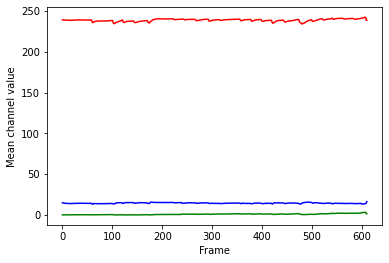

In [ ]:
plt.plot(x, red_channel, label='Red channel', color='r')
plt.plot(y, blue_channel, label='Blue channel', color='b')
plt.plot(z, green_channel, label='Green channel', color='g')

plt.xlabel('Frame')
plt.ylabel('Mean channel value')
plt.show()

To extract heart rate from the signal, I can use green and red channels.  Light with longer wavelengths penetrates more deeply into the tissue. Red light has more penetration power than green light. 
However, red light is susceptible to motion artifacts which would require additional filtering.  Thus, we use green light as it has a shorter wavelength and absorbs well into the skin.

Heart rate lies between 40-230 bpm, all other frequencies are considered as noise.

Also, intital video might contain more motion noise as the finger is not stabilised. I have skipped the 3 seconds from the start of the video to allow this stabilization.



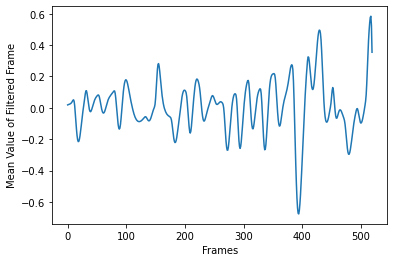

In [ ]:
## Pre-processing
# bandpass filtering: heart rate can only lie between 40-230 bpm
filtered_green = butter_bandpass_filter(green_channel, (40/60)/fps , (230/60)/fps , fps)

# clip start of video for stabilization
st = 3  #stabilization seconds
filtered_green = filtered_green[int(fps * st + 1) : len(filtered_green)]
plt.plot(filtered_green)
plt.xlabel('Frames')
plt.ylabel('Mean Value of Filtered Frame')
plt.show()

Algorithm 1: Time series peak detection
The number of peaks correspond the heart rate

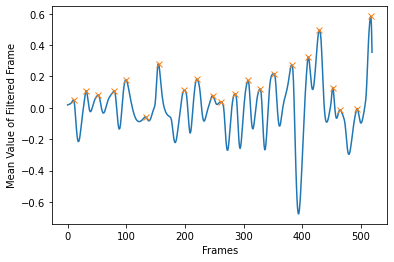

Heart Rate:  76.00767754318618 bpm


In [ ]:
# Peak detection approach on filtered data
peaks, _ = find_peaks(filtered_green)

plt.plot(filtered_green)
plt.plot(peaks, filtered_green[peaks], "x")
plt.xlabel('Frames')
plt.ylabel('Mean Value of Filtered Frame')
plt.show()

print("Heart Rate: ", abs(len(peaks) / ((totalFrames/fps) - st)) * 60, "bpm")

Algorithm 2: Fast Fourier Transform 
The frequency with highest magnitude corrsonds to heart rate frequency

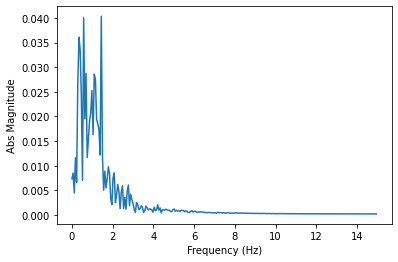

Heart Rate:  86.53846153846153 bpm


In [ ]:
# FFT based peak detection
N = len(filtered_green)

fft_green = np.abs(np.fft.fft(filtered_green)/N)[0:int(N/2)]
fft_freq = np.fft.fftfreq(N, d = 1/fps)[0:int(N/2)]
plt.plot(fft_freq, fft_green)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Abs Magnitude')
plt.show()

heart_rate_freq_green = np.argmax(fft_green)
print("Heart Rate: ", fft_freq[heart_rate_freq_green] * 60, "bpm")